## 1. Ridge Regression with Offset

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
csv ='./linear.csv'
data = np.genfromtxt(csv,delimiter=',')

In [3]:
vX = data[:10,1:]
tX = data[10:,1:]
vY = data[:10,0]
tY = data[10:,0]

In [4]:
print(vX.shape)
print(tX.shape)
print(vY.shape)
print(tY.shape)

(10, 4)
(40, 4)
(10,)
(40,)


In [5]:
lamb = 0.15
d = 4
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None,d], name='x')
y = tf.placeholder(tf.float32, [None], name='y')
lr = tf.placeholder(tf.float32,[],name='lr')
y_reshaped = tf.reshape(y,[-1,1])
with tf.name_scope("gd"):
    w = tf.get_variable('weights', shape=[d+1,1], initializer=tf.zeros_initializer)
msr = tf.reduce_mean(tf.square(tf.matmul(x,w[:-1]) + w[-1] - y_reshaped))/2
ridge = lamb/2 * tf.reduce_sum(tf.square(w[:-1]))
loss = msr + ridge#Ridge Regression
grad_loss = tf.gradients(loss,[w])

train_op = [w.assign(w - lr*grad_loss[0]),
           loss]

[[-0.5521016 ]
 [ 1.1864958 ]
 [ 0.04831377]
 [-0.66892546]
 [-1.1273942 ]]


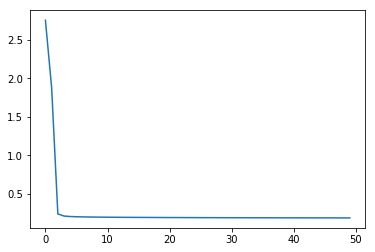

In [6]:
n_epoch = 50
losses_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_epoch):
        lr_in = 1/(i+1)
        w_out,loss_out = sess.run(train_op,feed_dict={x:tX,y:tY,lr:lr_in})
        losses_list.append(loss_out)
    print(w_out)
plt.plot(range(n_epoch),losses_list)

4th feature should be irrelevant since it's all 1s.

### BFGS Optimizer

In [7]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b as minimize

In [8]:
lamb = 0.15

def costgrad(w,x,y):
    n = len(x)
    x_ = np.concatenate((x,np.full([x.shape[0],1],1)), axis=1)
    xw = np.matmul(x_,w)
    msr = np.mean((xw - y)**2)/2
    ridge = lamb/2*np.sum(w[:-1]**2)
    cost = msr + ridge
    grad = lamb*np.concatenate((w[:-1],[0])) + np.matmul(np.matmul(np.transpose(x_),x_),w)/n - np.matmul(np.transpose(x_),y)/n
    return cost,grad

In [9]:
w = np.zeros([5])
optx,cost,messages = minimize(costgrad,w,args=[tX,tY])
print('w:{}'.format(optx))

w:[-5.35914964e-01  1.20292986e+00  4.33367252e-02 -7.33654720e-06
 -1.85491432e+00]


### Exact solution

In [10]:
def ridge_regression(tX, tY, lamb):
    x_ = np.concatenate((tX,np.full([tX.shape[0],1],1)), axis=1)
    J = np.diag(np.array([1.,1.,1.,1.,0.]))
    n = len(tX)
    inv = np.linalg.inv(n*lamb*J + np.matmul(np.transpose(x_),x_))
    w = np.matmul(np.matmul(inv,np.transpose(x_)),tY)
    return w

In [11]:
print('w:{}'.format(ridge_regression(tX,tY,0.15)))

w:[-0.53590673  1.20293332  0.04334568  0.         -1.85492455]


### Plot validation loss and training loss as lambda varies

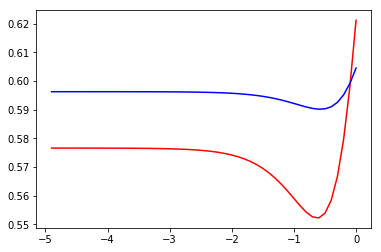

In [12]:
tn = tX.shape[0]
vn = vX.shape[0]
tloss = []
vloss = []
index = -np.arange(0,5,0.1)
for i in index:
    w = ridge_regression(tX,tY,10**i)
    tloss = tloss+[np.sum((np.dot(tX,w[:-1])-tY)**2)/tn/2]
    vloss = vloss+[np.sum((np.dot(vX,w[:-1])-vY)**2)/vn/2]
import matplotlib.pyplot as plt
plt.plot(index,np.log(tloss),'r')
plt.plot(index,np.log(vloss),'b')

In [13]:
print('lambda that minimises validation loss:{}'.format(10**index[np.argmin(vloss)]))

lambda that minimises validation loss:0.25118864315095796


## 2. Clustering

In [14]:
%matplotlib inline
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import random

In [15]:
n_colors = 32
pic = 'https://www.dropbox.com/s/bmwwfct2qxjfje4/sutd.png?dl=1'
img = mpimg.imread(pic)
img = img[:,:,:3]

In [16]:
w,h,d = tuple(img.shape)
image_array = np.reshape(img, (w*h,d))

In [17]:
def recreate_image(palette, labels, w, h):
    d = palette.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

In [18]:
np.random.seed(1)
random_sample = random.choices(image_array,k=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(random_sample)
kmeans_palette = kmeans.cluster_centers_
kmeans_labels = kmeans.predict(image_array)

In [19]:
random_palette = np.array(random.choices(image_array,k=32))
random_labels = np.array(pairwise_distances_argmin(image_array,random_palette))

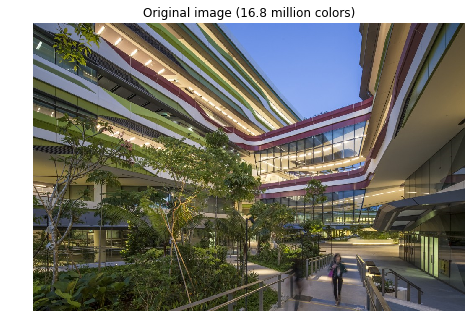

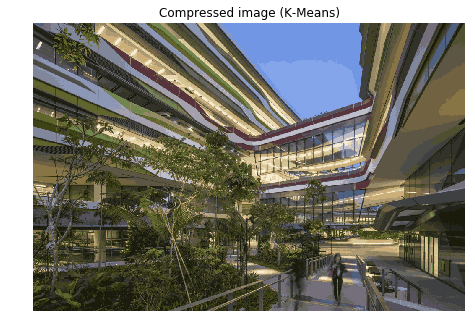

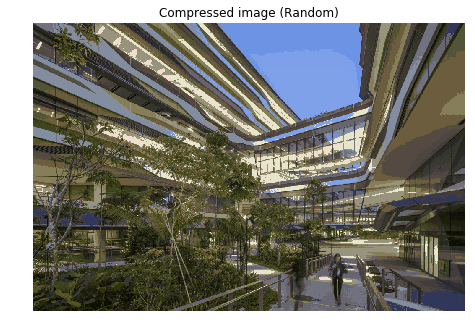

In [20]:
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (16.8 million colors)')
plt.imshow(img)
plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Compressed image (K-Means)')
plt.imshow(recreate_image(kmeans_palette, kmeans_labels, w, h))
plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Compressed image (Random)')
plt.imshow(recreate_image(random_palette, random_labels, w, h))
plt.show()

2c. Proof that z minimize

In [21]:
%%latex
$$L = \sum_{i=1}^{m}\lVert x^{(i)}-z \rVert^{2}$$
$$\frac{\partial L}{\partial z} = -2\sum_{i=1}^{m} (x^{(i)}-z) $$
When z minimize the equation,
$$-2\sum_{i=1}^{m} (x^{(i)}-z) = 0$$
$$-mz + \sum_{i=1}^{m} x^{(i)} = 0$$
Hence,
$$z = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}$$

<IPython.core.display.Latex object>

## 3. Logistic Regression

In [22]:
import numpy as np
import pandas as pd

In [23]:
X_data = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
X_valid = X_data.sample(frac=0.2,random_state=200)
X_train = X_data.drop(X_valid.index)
Y_data= X_data["Survived"]
Y_valid = X_valid["Survived"]
Y_train = X_train["Survived"]
ID_test = X_test["PassengerId"]

In [24]:
from IPython.display import display
display(X_data.head())
display(X_data.describe(include="all"))
display(X_test.head())
display(X_test.describe(include="all"))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Moubarek, Master. Gerios",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [25]:
def preprocess(df):
    df.drop(["Survived"],axis=1, inplace=True,errors="ignore")
    df.drop(["PassengerId","Name","Ticket","Cabin"],axis=1,inplace=True)

    df["Embarked"].fillna(df["Embarked"].mode()[0],inplace=True)
    df["Fare"].fillna(df["Fare"].median(),inplace=True)
    df["Age"].fillna(df["Age"].mean(),inplace=True)

    df = df.join(pd.get_dummies(df["Embarked"]))
    df.drop(["Embarked"],axis=1,inplace=True)
    df = df.join(pd.get_dummies(df["Sex"]))
    df.drop(["Sex"],axis=1,inplace=True)
    df = df.join(pd.get_dummies(df["Pclass"]))
    df.drop(["Pclass"],axis=1,inplace=True)

    df["Family"] = 0
    df["Child"] = 0
    df.loc[(df["SibSp"] != 0) | (df["Parch"] != 0), "Family"] = 1
    df.loc[df["Age"] < 16,"Child"] = 1
    
    return df

In [26]:
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_data = preprocess(X_data)
X_test = preprocess(X_test)
display(X_train.head())

,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
0,22.000000,1,0,7.2500,0,0,1,0,1,0,0,1,1,0
2,26.000000,0,0,7.9250,0,0,1,1,0,0,0,1,0,0
3,35.000000,1,0,53.1000,0,0,1,1,0,1,0,0,1,0
4,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1,0,0
5,29.449243,0,0,8.4583,0,1,0,0,1,0,0,1,0,0


In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)
lr.score(X_valid,Y_valid)

0.7921348314606742

In [29]:
lr2 = LogisticRegression()
lr2.fit(X_data,Y_data)
lr2.coef_

array([[-0.02253956, -0.59968738, -0.31836257,  0.00310565,  0.18025093,
         0.29882425, -0.11221425,  1.48379758, -1.11693665,  1.00892024,
         0.21604645, -0.85810575,  0.69217133,  1.18794225]])

In [30]:
Y_test = lr2.predict(X_test)

In [31]:
ans = pd.DataFrame({"PassengerId":ID_test,"Survived":Y_test})

In [32]:
ans.to_csv("submit.csv", index=False)